# Deep model for *rate* variable classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import os
from sklearn.utils import class_weight
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import  confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


## Useful functions

In [0]:
def load_data():
    train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/zmum/data/Train.csv", sep=";", error_bad_lines=False)
    test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/zmum/data/TestX.csv", sep=";", error_bad_lines=False)
    return train, test


def prepare_inputs(X_train, X_val, X_test):
    X_train_enc, X_val_enc, X_test_enc = list(), list(), list()
    # label encode each column

    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        # le.fit(X_train[:, i])
        # le.fit(np.concatenate((X_train[:, i], X_test[:, i]), axis=0).astype(str))
        le.fit(np.concatenate((X_train[:, i], X_val[:, i], X_test[:, i]), axis=0))
        # encode
        train_enc = le.transform(X_train[:, i])
        val_enc = le.transform(X_val[:, i])
        test_enc = le.transform(X_test[:, i])
        # store
        X_train_enc.append(train_enc)
        X_val_enc.append(val_enc)
        X_test_enc.append(test_enc)
        
    return X_train_enc, X_val_enc, X_test_enc


def prepare_outputs(X_train, X_test):
    X_train_enc, X_test_enc = list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        # le.fit(X_train[:, i])
        # le.fit(np.concatenate((X_train[:, i], X_test[:, i]), axis=0).astype(str))
        le.fit(np.concatenate((X_train[:, i], X_test[:, i]), axis=0))
        # encode
        train_enc = le.transform(X_train[:, i])
        test_enc = le.transform(X_test[:, i])
        # store
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
    return X_train_enc, X_test_enc


def train_val_split(train_data, rate=0.9, unique=True, seed=17):
    if unique == True:
        unique_opinions = pd.unique(train_data["opinion"].values)
        train = train_data.loc[train_data["opinion"].isin(unique_opinions[:int(unique_opinions.shape[0]*rate)])]
        val = train_data.loc[train_data["opinion"].isin(unique_opinions[int(unique_opinions.shape[0]*rate):])]
        return train, val
    else:
        train, val = train_test_split(train_data, test_size=(1-rate), random_state=seed)
        return train, val 

def decode_sentence(text, reverse_word_index):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


def plot_history(history, metric="rate_"):
    # Plot training & validation accuracy values
    plt.plot(history.history[metric + 'accuracy'])
    plt.plot(history.history['val_' + metric + 'accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history[metric + 'loss'])
    plt.plot(history.history['val_' + metric + 'loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12,9))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



def load_all_models(path="/content/drive/My Drive/Colab Notebooks/zmum/models/concat_three_out_rindex_bigger2", maxim=10):
    all_models = []
    models_list = [os.path.join(path, elem) for elem in os.listdir(path)]
    for i, mod in enumerate(models_list):
        # load model from file
        model = tf.keras.models.load_model(mod)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % model)
        if i == maxim:
            break
    return all_models

def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = np.dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for j, layer in enumerate(model.layers):
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
            # if j==len(model.layers)-6:
            #     print(layer)
            #     break

    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    ensemble_visible = [y for x in ensemble_visible for y in x]
    print(ensemble_visible)
    # concatenate merge output from each model
    # ensemble_outputs = [model.layers[len(model.layers)-4] for model in members]
    ensemble_outputs = [model.output for model in members]
    ensemble_outputs = [y for x in ensemble_outputs for y in x]
    print(ensemble_outputs)
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    hidden = tf.keras.layers.Dense(100, activation='relu')(merge)
    dense = tf.keras.layers.Dense(100, activation='relu')(hidden)
    output = tf.keras.layers.Dense(10, activation='softmax', name="rate")(dense)
    output2 = tf.keras.layers.Dense(3, activation='softmax', name="rate1")(dense)
    output3 = tf.keras.layers.Dense(1, activation='relu', name="rate_reg")(dense)
    model = tf.keras.models.Model(inputs=ensemble_visible, outputs=[output, output2, output3])
    model.summary()

    # model = keras.models.Model(inputs=ensemble_visible, outputs=output)
    # compile
    # model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    model.compile(
    # optimizer=tf.keras.optimizers.RMSprop(1e-3),
    optimizer='adam',
    loss={
        "rate": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        "rate1": tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        "rate_reg": tf.keras.losses.MeanAbsoluteError(),
    },
    loss_weights=[1.0, 0.2, 1],
    metrics=[['accuracy'], ['accuracy'], ['mae']]
    )
    return model

## code

#### define static vars

In [0]:
VOCAB_SIZE = 5000
EMB_DIM = 64
MAX_LEN = 400
TRUNC_TYPE = 'post'
PAD_TYPE = 'post'
OOV_TOK = '<OOV>'

#### load and preprocess dataset

In [5]:
train_index = pd.read_csv("/content/drive/My Drive/Colab Notebooks/zmum/data/train_index.csv", header=None).drop(columns=[0])
val_index = pd.read_csv("/content/drive/My Drive/Colab Notebooks/zmum/data/test_index.csv", header=None).drop(columns=[0])
train_index.iloc[:,0].values

array([132170,   1782,  95502, ..., 148341, 148442, 148548])

In [6]:
members = load_all_models(path="/content/drive/My Drive/Colab Notebooks/zmum/models/three_easy", maxim=15)

>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f374879d3c8>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f374822e358>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f3748061c50>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f37479700f0>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f37477f78d0>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f37471250f0>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f3746d0bd30>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f37468e7d68>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f37467de048>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f374611cd68>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f3745d27a58>
>loaded <tensorflow.python.keras.engine.training.Model object at 0x7f3745c12710>


In [7]:
print('Loaded %d models' % len(members))

Loaded 12 models


##META MODEL

In [0]:
model = define_stacked_model(members) 
# tf.keras.utils.plot_model(model, show_shapes=True) 

In [10]:
train, test = load_data()
train, test = train.dropna(), test.dropna()
# train, val = train_val_split(train, rate=0.9)
train, val = train_val_split(train, rate=0.9, unique=False)
# train, val = train.iloc[train_index.iloc[:,0].values], train.iloc[val_index.iloc[:,0].values]
train, val = train.reset_index(), val.reset_index()


train_posts, val_posts, test_posts = train['opinion'], val['opinion'], test['opinion']
X_train_enc, X_val_enc, X_test_enc = prepare_inputs(train[["name", "condition"]].values, val[["name", "condition"]].values, test[["name", "condition"]].values)
# train_labels, val_labels = train['rate1'], val['rate1']
train_labels, val_labels= prepare_outputs(train[['rate', 'rate1']].values, val[['rate', 'rate1']].values)
# train_labels, val_labels = train_labels[0], val_labels[0]
print("train shape: {}, val shape: {}".format(train.shape, val.shape))

train shape: (134244, 6), val shape: (14917, 6)


In [0]:
X_test_enc

[array([3143, 1515,  491, ..., 3208,  211, 1003]),
 array([802, 136,  95, ...,  50, 122,   0])]

#### class weights calculate

#### fit tokenizer on words in opiniions

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(pd.concat((train_posts, val_posts), axis=0))
word_index = tokenizer.word_index
print("sample tokens: ", dict(list(word_index.items())[0:100]))
print("sample tokens: ", dict(list(word_index.items())[4900:5000]))

sample tokens:  {'<OOV>': 1, 'i': 2, 'and': 3, 'the': 4, 'to': 5, 'it': 6, 'my': 7, 'a': 8, '039': 9, 'for': 10, 'was': 11, 'have': 12, 'of': 13, 'on': 14, 'this': 15, 'in': 16, 'but': 17, 'me': 18, 'had': 19, 'is': 20, 'that': 21, 'with': 22, 't': 23, 'not': 24, 'so': 25, 'been': 26, 'at': 27, 'after': 28, 'no': 29, 'day': 30, 'am': 31, 'as': 32, 'about': 33, 'm': 34, 'now': 35, 'side': 36, 'taking': 37, 'all': 38, 'has': 39, 've': 40, 's': 41, 'years': 42, 'pain': 43, 'effects': 44, 'first': 45, 'take': 46, 'you': 47, 'months': 48, 'only': 49, 'started': 50, '2': 51, 'like': 52, 'get': 53, 'up': 54, 'be': 55, 'days': 56, 'just': 57, 'very': 58, 'time': 59, 'out': 60, 'from': 61, 'or': 62, 'when': 63, '3': 64, 'can': 65, 'feel': 66, 'if': 67, 'would': 68, 'because': 69, 'back': 70, 'pill': 71, 'more': 72, 'one': 73, 'weeks': 74, 'are': 75, 'week': 76, 'doctor': 77, 'also': 78, 'took': 79, 'period': 80, 'medication': 81, 'weight': 82, 'before': 83, 'then': 84, 'got': 85, 'will': 86, 'd

#### tokenize words in opinions in train and val dataset


In [12]:
train_sequences = tokenizer.texts_to_sequences(train_posts)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_LEN,
                                                             padding=PAD_TYPE, truncating=TRUNC_TYPE)
validation_sequences = tokenizer.texts_to_sequences(val_posts)
validation_padded = tf.keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=MAX_LEN,
                                                                  padding=PAD_TYPE, truncating=TRUNC_TYPE)

test_sequences = tokenizer.texts_to_sequences(test_posts)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_LEN,
                                                                  padding=PAD_TYPE, truncating=TRUNC_TYPE)
print("sample tokenized sentence: ", train_sequences[10])
print("sample tokenized sentence: ", test_sequences[10])

sample tokenized sentence:  [2, 12, 26, 37, 2827, 3980, 10, 33, 2323, 48, 63, 2, 411, 14, 4, 141, 2, 12, 144, 62, 29, 70, 43, 67, 2, 203, 10, 123, 112, 56, 4, 43, 741, 70, 17, 219, 2, 283, 131, 4, 43, 20, 238, 16, 73, 62, 112, 56, 6, 39, 190, 18, 1397]
sample tokenized sentence:  [7, 1159, 20, 427, 130, 51, 42, 199, 3, 39, 26, 998, 16, 8, 3475, 503, 10, 4, 313, 138, 42, 145, 122, 228, 569, 157, 98, 24, 101, 143, 4517, 13, 154, 282, 224, 400, 636, 3346, 27, 4, 3778, 13, 4, 567, 4, 3475, 503, 160, 400, 14, 246, 150, 744, 3, 400, 171, 791, 224, 154, 421, 22, 29, 36, 44, 228, 11, 1, 131, 3, 11, 1808, 5, 46, 92, 32, 6, 326, 400, 270, 5, 213, 67, 228, 155, 596, 14, 8, 438, 148, 33, 8, 88, 132, 110, 982, 400, 148, 5, 138, 150, 3, 4, 98, 1002, 316, 400, 148, 11, 1293, 70, 54, 5, 246, 150, 3, 260, 75, 1, 8, 1339, 5, 400, 615, 561, 612]


#### check tokenization

In [13]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original: ", train_posts[0])
print('---')
print("Tokenized then decoded: ", decode_sentence(train_padded[0], reverse_word_index))

Original:  "I&#039;ve been on lex for almost a month and so far my side effects have been minimal. The first week, although I didn&#039;t have anxiety problems, it seemed to spark a few anxiety episodes. Nothing major. I started with 10mg and today is my first day of 20mgs. I&#039;m a little worried about side effects. I&#039;m still having a problem wanting to get out of bed. I just feel like I have no energy to do anything and I hate this feeling hence the increase to 20mgs. I&#039;m going to stick with it because although I&#039;m still struggling with the lack of energy, is helped at least put a few smiles back on my face here and there. All I know is I want to get better, I have to get better! 
Good luck everyone I&#039;ll check back in 3 or 4 wks &amp; give a complete update."
---
Tokenized then decoded:  i 039 ve been on <OOV> for almost a month and so far my side effects have been minimal the first week although i didn 039 t have anxiety problems it seemed to <OOV> a few anxiet

#### conversion to one hot variables

In [14]:
#%% convert integers to dummy variables (i.e. one hot encoded)
train_labels_one_hot = []
val_labels_one_hot = []


train_labels_one_hot.append(tf.keras.utils.to_categorical(train_labels[0]))
train_labels_one_hot.append(tf.keras.utils.to_categorical(train_labels[1]))

val_labels_one_hot.append(tf.keras.utils.to_categorical(val_labels[0]))
val_labels_one_hot.append(tf.keras.utils.to_categorical(val_labels[1]))

# train_labels_one_hot = tf.keras.utils.to_categorical(train_labels)
# val_labels_one_hot = tf.keras.utils.to_categorical(val_labels)
# print(f"shape: {train_labels_one_hot.shape} one hot encoded: {train_labels_one_hot}")
print(f"shape: {len(train_labels_one_hot)} one hot encoded: {train_labels_one_hot}")

shape: 2 one hot encoded: [array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32), array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)]


In [0]:
train_labels[0]

array([2, 8, 7, ..., 7, 8, 8])

### Callbacks


In [0]:
run_path = "/content/drive/My Drive/Colab Notebooks/zmum/models/meta_model_easy"
earlyStopping = EarlyStopping(monitor='rate_accuracy', patience=10, verbose=0)
mcp_save = ModelCheckpoint(os.path.join(run_path, 'model-{epoch:03d}-{val_rate_accuracy:03f}-{val_rate1_accuracy:03f}.h5'),
                           save_best_only=True, monitor='rate_accuracy', patience=7)
reduce_lr_loss = ReduceLROnPlateau(monitor='rate_accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4)

callbacks = [earlyStopping, mcp_save, reduce_lr_loss]


#### model training and history

In [0]:

num_epochs = 10

# model.load_weights("/content/drive/My Drive/Colab Notebooks/zmum/models/meta_model/model-003-0.418609-0.752260.h5")
# model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/zmum/models/meta_model/model-003-0.418609-0.752260.h5")

In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ensemble_1_ensemble_1_input_1 ( [(None, 400)]        0                                            
__________________________________________________________________________________________________
ensemble_2_ensemble_2_input_1 ( [(None, 400)]        0                                            
__________________________________________________________________________________________________
ensemble_3_ensemble_3_input_1 ( [(None, 400)]        0                                            
__________________________________________________________________________________________________
ensemble_4_ensemble_4_input_1 ( [(None, 400)]        0                                            
____________________________________________________________________________________________

In [18]:

history = model.fit(
    # [[{"input_1": train_padded, "input_2": X_train_enc[0], "input_3": X_train_enc[1]},
    # [{f"ensemble_{i}_input_1": train_padded, f"ensemble_{i}_input_2": X_train_enc[0], f"ensemble_{i}_input_3": X_train_enc[1]} for i in range(len(members))],
    [{f"ensemble_{i}_input_1": X_train_enc[0], f"ensemble_{i}_input_2": X_train_enc[1], f"ensemble_{i}_input_3": train_padded} for i in range(len(members))],
    # [[train_padded, X_train_enc[0], X_train_enc[1]] for _ in range(len(members))],
    {"rate": train_labels_one_hot[0], "rate1": train_labels_one_hot[1], "rate_reg": train_labels[0]},
    # {"rate_ens": train_labels_one_hot[0], "rate1_ens": train_labels_one_hot[1], "rate_reg_ens": train_labels[0]},
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    # validation_data=([{"input_1": validation_padded, "input_2": X_val_enc[0], "input_3": X_val_enc[1]},
    #                     {"rate": val_labels_one_hot[0], "rate1": val_labels_one_hot[1], "rate_reg": val_labels[0]} range(len(members))])
    validation_data=([{f"ensemble_{i}_input_1": X_val_enc[0], f"ensemble_{i}_input_2": X_val_enc[1], f"ensemble_{i}_input_3": validation_padded} for i in range(len(members))],
                      {"rate": val_labels_one_hot[0], "rate1": val_labels_one_hot[1], "rate_reg": val_labels[0]})
    # validation_split=0.2
)

Epoch 1/10
1049/1049 [==============================] - 3917s 4s/step - loss: 2.3480 - rate_loss: 1.7706 - rate1_loss: 0.6291 - rate_reg_loss: 0.4516 - rate_accuracy: 0.6973 - rate1_accuracy: 0.9242 - rate_reg_mae: 0.4516 - val_loss: 3.0250 - val_rate_loss: 1.9262 - val_rate1_loss: 0.7161 - val_rate_reg_loss: 0.9556 - val_rate_accuracy: 0.5331 - val_rate1_accuracy: 0.8341 - val_rate_reg_mae: 0.9556 - lr: 0.0010
Epoch 2/10
  64/1049 [>.............................] - ETA: 56:01 - loss: 2.2665 - rate_loss: 1.7109 - rate1_loss: 0.6126 - rate_reg_loss: 0.4330 - rate_accuracy: 0.7535 - rate1_accuracy: 0.9382 - rate_reg_mae: 0.4330

KeyboardInterrupt: ignored

In [0]:
plot_history(history)


#### confusion matrix

In [0]:
predictions = model.predict([{f"ensemble_{i}_input_1": X_val_enc[0], f"ensemble_{i}_input_2": X_val_enc[1], f"ensemble_{i}_input_3": validation_padded} for i in range(12)])

In [20]:
predictions

[array([[1.71361574e-08, 1.83098292e-09, 4.26203545e-10, ...,
         4.65278936e-06, 9.99993443e-01, 3.92592398e-07],
        [4.43630288e-09, 1.15669225e-08, 9.13840381e-08, ...,
         2.76059297e-11, 3.29350257e-07, 4.82109570e-08],
        [3.36360017e-07, 1.57483768e-07, 5.06835596e-09, ...,
         1.86897611e-04, 8.44779730e-01, 1.54990867e-01],
        ...,
        [1.04409761e-08, 2.27116015e-08, 1.60182793e-07, ...,
         1.54927605e-07, 5.06838319e-07, 3.58583065e-08],
        [2.41457858e-08, 1.86493789e-08, 3.59314078e-10, ...,
         2.15224445e-05, 2.30138074e-03, 9.97673810e-01],
        [1.67543831e-07, 2.96162561e-08, 3.40557249e-09, ...,
         3.44036263e-04, 9.99629498e-01, 1.58575458e-05]], dtype=float32),
 array([[9.99785841e-01, 8.84064320e-06, 2.05327669e-04],
        [1.36468543e-08, 2.53610580e-07, 9.99999762e-01],
        [9.99912381e-01, 1.03676330e-05, 7.72872008e-05],
        ...,
        [2.42321022e-07, 5.09015535e-07, 9.99999285e-01],
     

### Rate confusion matrix

#### Classification

Confusion matrix, without normalization
[[1472   98   68   47   60   41   17   35   27   60]
 [ 312  107   83   30   33   24    9   16   11   17]
 [ 137   50  156   74   56   31   18   31   14   18]
 [  67   17   65   98  108   41   26   34   14   14]
 [  56   19   25   34  293  102   47   67   40   37]
 [  28    9   18   18   86  157   83   96   54   31]
 [  15    9   14   19   59  107  242  210  155   81]
 [  22    9   15   19   43   59  127  668  434  361]
 [  20    6   13   12   26   39   67  317 1128  937]
 [  24    7   15   22   29   41   54  225  700 3631]]


0.5330830595964337

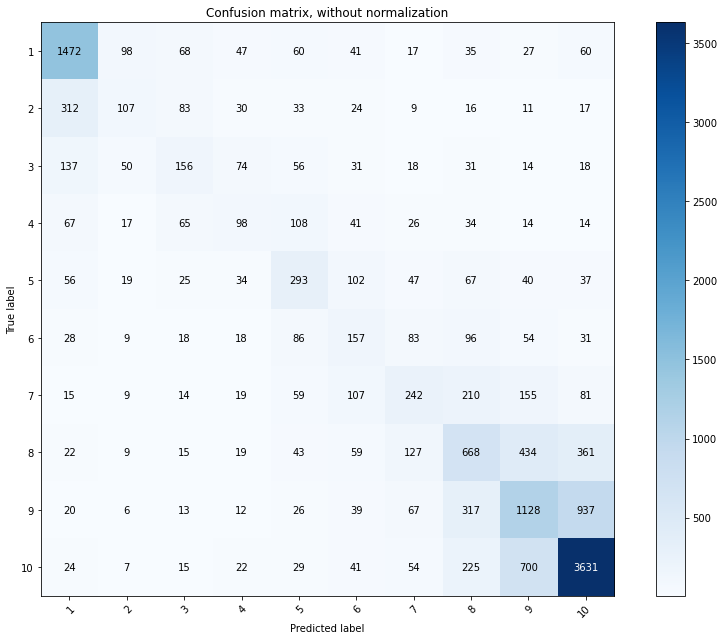

In [21]:
y_pred = np.argmax(predictions[0], axis=1)
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[0], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[0], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[0]) if x == y) / len(y_pred)


#### Rounding to nearest int

Confusion matrix, without normalization
[[1477   98   79   45   56   30   28   37   28   47]
 [ 326  104   84   20   37   15   16   16   11   13]
 [ 138   63  180   45   55   22   20   34   15   13]
 [  70   21   91   89   95   23   34   35   14   12]
 [  58   20   29   54  282   76   58   72   45   26]
 [  28   14   16   23   93  117  109  106   45   29]
 [  14   11   19   19   62   67  274  223  143   79]
 [  22    9   22   17   47   42  129  706  418  345]
 [  21    7   11   14   24   28   78  355 1098  929]
 [  22    9   18   25   34   27   62  246  662 3643]]


0.5342897365422001

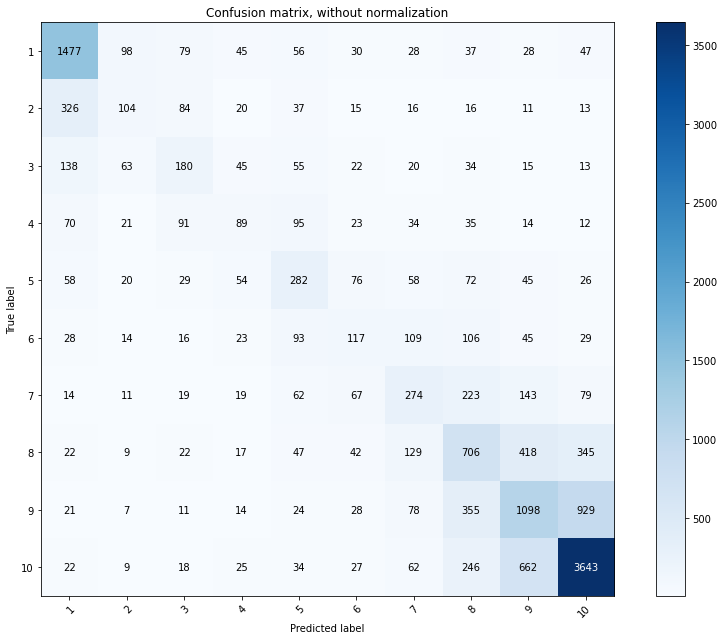

In [22]:
# y_pred = predictions[2].astype('int') 
y_pred = [round(elem[0]) for elem in predictions[2]]
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[0], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[0], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[0]) if x == y) / len(y_pred)


#### Float projection to int

Confusion matrix, without normalization
[[1539   90   49   60   31   33   42   17   36   28]
 [ 387  107   31   31   25   14   15   13   14    5]
 [ 167  174   64   52   37   20   32   17   17    5]
 [  75   65   87  107   44   31   35   19   17    4]
 [  69   27   28  222  141   61   86   33   35   18]
 [  36   18   15   55  102  132  114   52   38   18]
 [  16   20   18   36   62  168  299  102  147   43]
 [  26   19   14   31   43   70  574  333  427  220]
 [  22   12   14   19   23   45  255  369 1141  665]
 [  27   12   18   38   24   42  174  258 1294 2861]]


0.4507608768519139

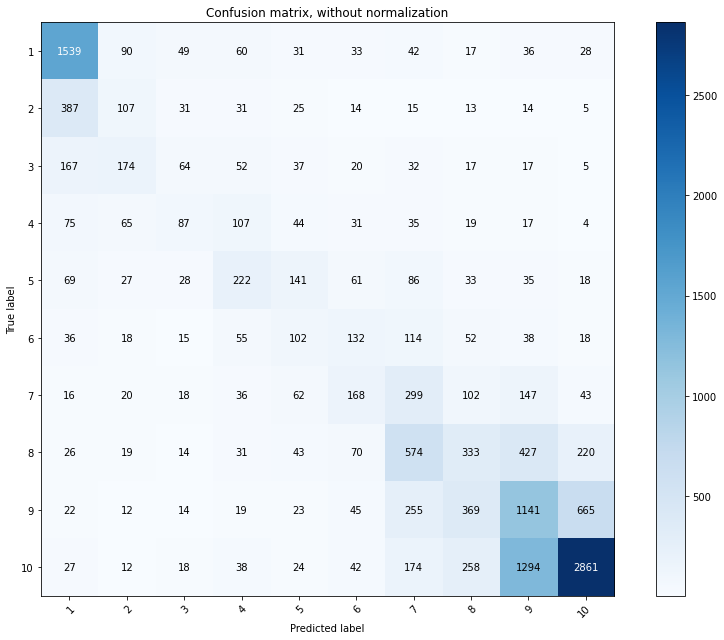

In [23]:
y_pred = predictions[2].astype('int') 
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[0], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[0], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[0]) if x == y) / len(y_pred)

### Rate1 confusion matrix

#### Classification


Confusion matrix, without normalization
[[8404  127  539]
 [ 226 2500  426]
 [ 822  357 1516]]


0.8326070925789368

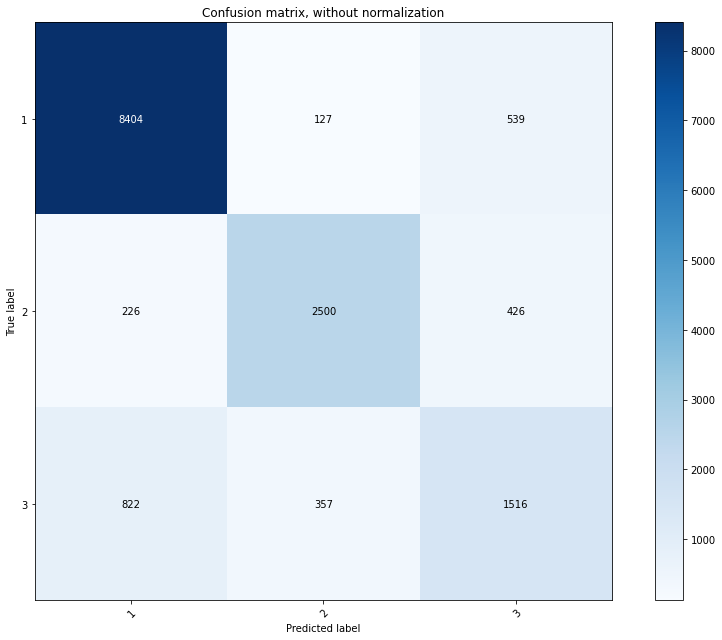

In [26]:
y_pred = np.argmax(predictions[1], axis=1)
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[1], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[1], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[1]) if x == y) / len(y_pred)


#### Based on rate


Confusion matrix, without normalization
[[8401  131  538]
 [ 229 2483  440]
 [ 833  342 1520]]


0.8315344908493665

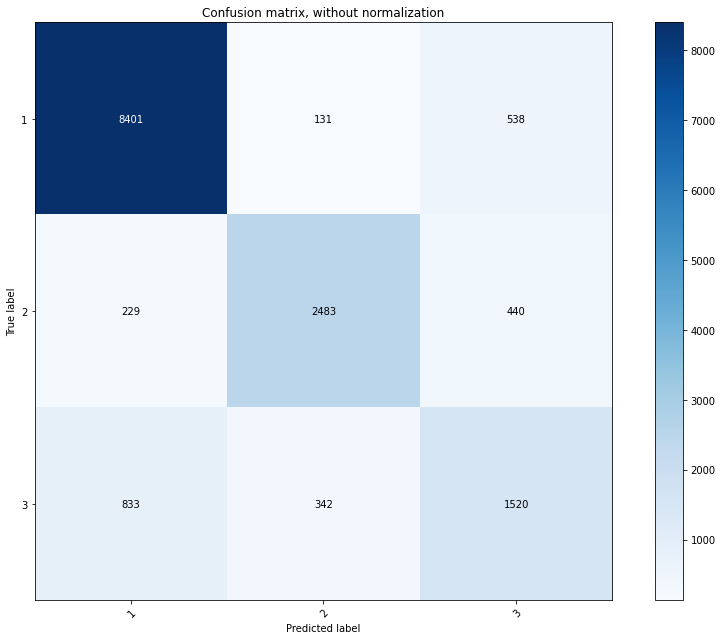

In [27]:
rate = np.argmax(predictions[0], axis=1)
rate+=1

y_pred = []
for i, elem in enumerate(rate):
    if elem <= 3:
        y_pred.append(1)
    elif 3 < elem < 8:
        y_pred.append(2)
    else:
        y_pred.append(0)

# y_pred = np.argmax(predictions[1], axis=1)
# y_pred += 1
cnf_matrix = confusion_matrix(val_labels[1], y_pred)
np.set_printoptions(precision=2)
cnf_matrix
plot_confusion_matrix(val_labels[1], y_pred, classes=list(range(1,11)),
                      title='Confusion matrix, without normalization')
sum(1 for x,y in zip(y_pred, val_labels[1]) if x == y) / len(y_pred)


# Test predictions

In [0]:
predictions_test = model.predict([{f"ensemble_{i}_input_1": X_test_enc[0], f"ensemble_{i}_input_2": X_test_enc[1], f"ensemble_{i}_input_3": test_padded} for i in range(12)])
predictions_test

In [0]:
pred_test = predictions_test
rate = np.argmax(pred_test[0], axis=1)
rate+=1
rate1_tmp = np.argmax(pred_test[1], axis=1)
rate1 = []
for i, elem in enumerate(rate):
    if elem <= 3:
        rate1.append("low")
    elif 3 < elem < 8:
        rate1.append("medium")
    else:
        rate1.append("high")
rate1 = np.asanyarray(rate1)
df = pd.DataFrame(data = np.concatenate([np.expand_dims(rate, axis=1), np.expand_dims(rate1, axis=1)], axis=1), columns=["rate", "rate1"])
df.head(100)
df.to_csv("/content/drive/My Drive/Colab Notebooks/zmum/results_meta_easy.csv")